In [3]:
# ============================================================================
# IMPORTS ET CONFIGURATION
# ============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

# ============================================================================
# IMPORT DES DONNÉES
# ============================================================================
df = pd.read_csv('statistiques_grandes_villes_2020_2024_toutes_colonnes.csv', sep=';')
df.columns = df.columns.str.strip()

def corriger_annee(row):
    annee = row['annee']
    ville = row['ville']
    if pd.isna(annee):
        return None
    annee = int(annee)
    if ville == 'Lyon' and 20200 <= annee <= 20240:
        return 2020 + (annee - 20200) // 10
    if ville == 'Marseille' and 38380 <= annee <= 38460:
        return {38380: 2020, 38399: 2021, 38418: 2022, 38437: 2023, 38456: 2024}.get(annee)
    if ville == 'Paris' and 46460 <= annee <= 46560:
        return {46460: 2020, 46483: 2021, 46506: 2022, 46529: 2023, 46552: 2024}.get(annee)
    if 2020 <= annee <= 2024:
        return annee
    return None

df['annee_corrigee'] = df.apply(corriger_annee, axis=1)
df = df.dropna(subset=['annee_corrigee'])
df['annee'] = df['annee_corrigee'].astype(int)

df['prix_m2_moyen'] = pd.to_numeric(df['prix_m2_moyen'], errors='coerce')
df['nb_transactions'] = pd.to_numeric(df['nb_transactions'], errors='coerce')
df = df.dropna(subset=['prix_m2_moyen', 'ville'])

villes = sorted(df['ville'].unique())
print(f"✅ Données prêtes ({len(df)} lignes). Villes disponibles : {', '.join(villes)}")


✅ Données prêtes (45 lignes). Villes disponibles : Bordeaux, Grenoble, Lille, Lyon, Marseille, Montpellier, Paris, Rennes, Toulouse


In [4]:
# ===========================
# Cellule 1 — Sélection des villes
# ===========================
import ipywidgets as widgets
from IPython.display import display, clear_output

# On part du principe que 'df' existe déjà (chargé dans la cellule import/traitement).
# Créez ici les checkboxes — variable globale city_checkboxes utilisée ensuite.
city_checkboxes = [widgets.Checkbox(value=False, description=v) for v in sorted(df['ville'].unique())]

# Contrôles pratiques : Sélectionner tout / Décocher tout
btn_select_all = widgets.Button(description="Tout cocher", button_style='info')
btn_clear_all  = widgets.Button(description="Tout décocher", button_style='warning')

def select_all(b):
    for cb in city_checkboxes:
        cb.value = True

def clear_all(b):
    for cb in city_checkboxes:
        cb.value = False

btn_select_all.on_click(select_all)
btn_clear_all.on_click(clear_all)

# Affichage : titre + boutons + grille de checkboxes
grid = widgets.GridBox(city_checkboxes, layout=widgets.Layout(grid_template_columns="repeat(3, 220px)"))
ui_select = widgets.VBox([
    widgets.HBox([btn_select_all, btn_clear_all]),
    grid,
])

display(ui_select)


Affichage des données pour : Lyon, Montpellier, Toulouse



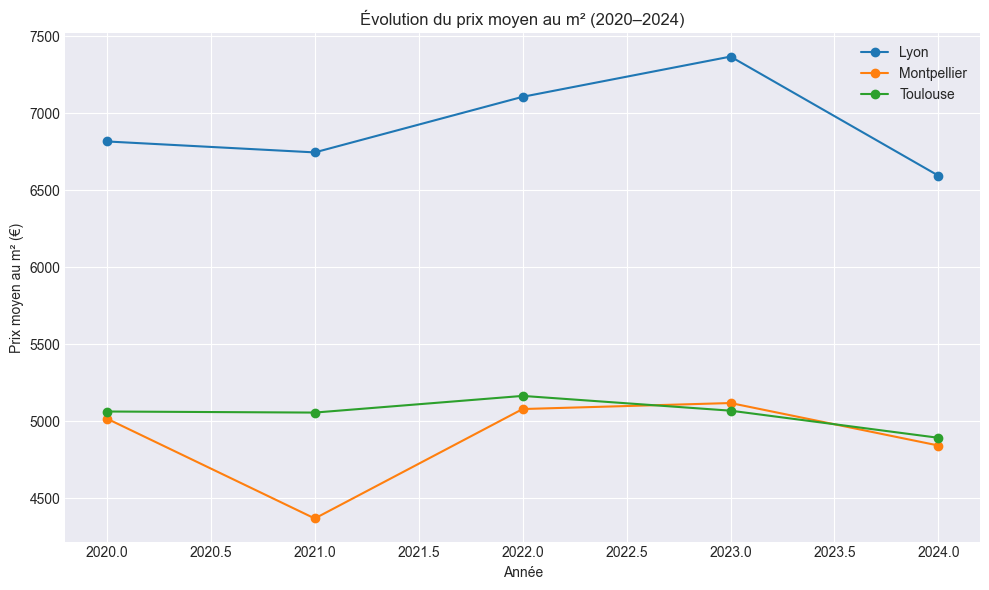

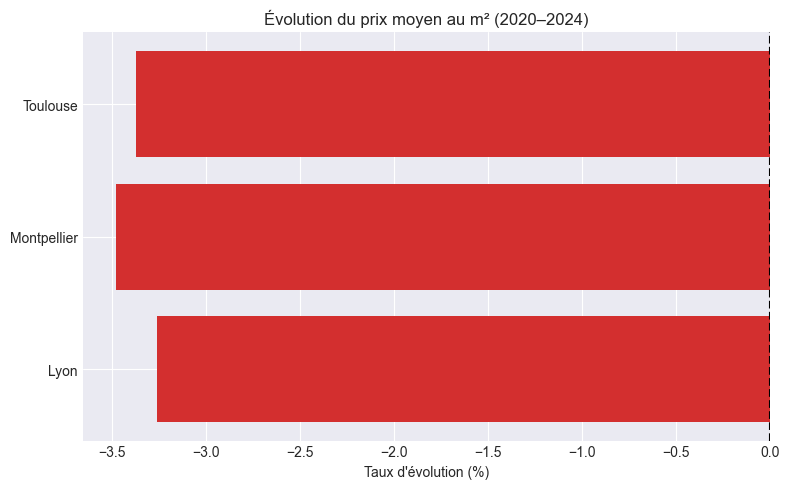

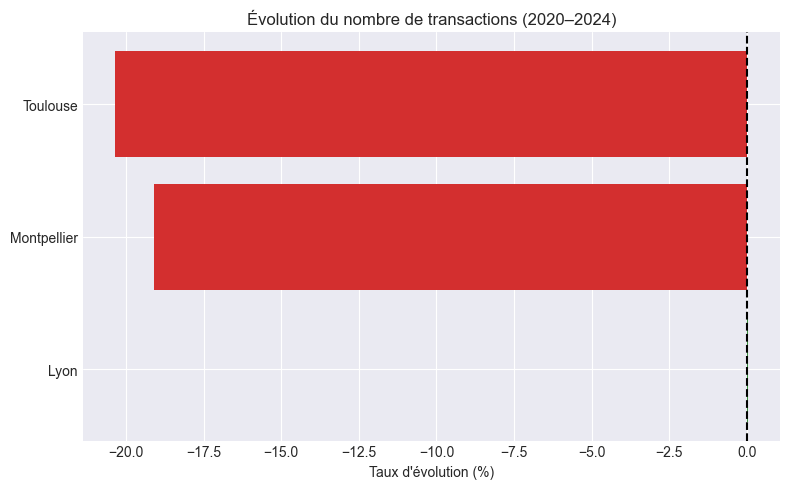

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Récupération dynamique des villes cochées
villes_selectionnees = [cb.description for cb in city_checkboxes if cb.value]

# Vérification
villes_existantes = [v for v in villes_selectionnees if v in df['ville'].unique()]
if not villes_existantes:
    print("⚠️ Aucune ville valide sélectionnée.")
else:
    print(f"Affichage des données pour : {', '.join(villes_existantes)}\n")

    # --------------------------------------------------------------------
    # 1️⃣ ÉVOLUTION DU PRIX MOYEN AU M²
    # --------------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    for ville in villes_existantes:
        data = df[df['ville'] == ville].sort_values('annee')
        plt.plot(data['annee'], data['prix_m2_moyen'], marker='o', label=ville)
    plt.title("Évolution du prix moyen au m² (2020–2024)")
    plt.xlabel("Année")
    plt.ylabel("Prix moyen au m² (€)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------------------
    # 2️⃣ TAUX D'ÉVOLUTION DU PRIX (2020 → 2024)
    # --------------------------------------------------------------------
    evol_prix = []
    for ville in villes_existantes:
        data = df[df['ville'] == ville]
        p2020 = data[data['annee'] == 2020]['prix_m2_moyen']
        p2024 = data[data['annee'] == 2024]['prix_m2_moyen']
        if len(p2020) and len(p2024) and p2020.iloc[0] != 0:
            taux = ((p2024.iloc[0] - p2020.iloc[0]) / p2020.iloc[0]) * 100
            evol_prix.append((ville, taux))
    if evol_prix:
        villes_graph, taux_graph = zip(*evol_prix)
        plt.figure(figsize=(8, 5))
        plt.barh(villes_graph, taux_graph, color=['#388E3C' if x >= 0 else '#D32F2F' for x in taux_graph])
        plt.title("Évolution du prix moyen au m² (2020–2024)")
        plt.xlabel("Taux d'évolution (%)")
        plt.axvline(x=0, color='black', linestyle='--')
        plt.tight_layout()
        plt.show()

    # --------------------------------------------------------------------
    # 3️⃣ ÉVOLUTION DU NOMBRE DE TRANSACTIONS
    # --------------------------------------------------------------------
    evol_trans = []
    for ville in villes_existantes:
        data = df[df['ville'] == ville]
        t2020 = data[data['annee'] == 2020]['nb_transactions']
        t2024 = data[data['annee'] == 2024]['nb_transactions']
        if len(t2020) and len(t2024) and t2020.iloc[0] != 0:
            taux = ((t2024.iloc[0] - t2020.iloc[0]) / t2020.iloc[0]) * 100
            evol_trans.append((ville, taux))

    if evol_trans:
        villes_graph, taux_graph = zip(*evol_trans)
        taux_graph = np.array(taux_graph, dtype=float)
        plt.figure(figsize=(8, 5))
        plt.barh(villes_graph, taux_graph, color=['#388E3C' if x >= 0 else '#D32F2F' for x in taux_graph])
        plt.title("Évolution du nombre de transactions (2020–2024)")
        plt.xlabel("Taux d'évolution (%)")
        plt.axvline(x=0, color='black', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Pas de données suffisantes pour afficher les transactions.")


In [13]:
# ======================================================================
# DASHBOARD INTERACTIF : COMPARAISON LOCATIVE ENTRE VILLES ÉTUDIANTES
# Affichage progressif des widgets
# ======================================================================

import pandas as pd
import ipywidgets as widgets
import plotly.express as px
from IPython.display import display, clear_output

# ============================================================================
# CHARGEMENT DES DONNÉES
# ============================================================================

fichier = "loyers_villes.csv"

try:
    df = pd.read_csv(fichier, sep=",", encoding="utf-8")
    print("Fichier chargé avec succès !")
    print(f"   Colonnes disponibles : {list(df.columns)}")
    print(f"   Villes disponibles : {df['Ville'].unique()}")
except Exception as e:
    print(f"❌ Erreur lors du chargement : {e}")
    raise

# ============================================================================
# FILTRAGE DES VILLES SÉLECTIONNÉES (depuis étape précédente)
# ============================================================================

# Vérifier que villes_selectionnees existe
if 'villes_selectionnees' not in globals():
    print("⚠️ Variable 'villes_selectionnees' non trouvée. Utilisation de toutes les villes.")
    villes_selectionnees = df["Ville"].unique().tolist()

# Filtrer les villes valides
villes_existantes = [v for v in villes_selectionnees if v in df["Ville"].unique()]

if not villes_existantes:
    print("❌ Aucune ville valide sélectionnée.")
    raise ValueError("Sélectionnez au moins une ville valide.")
else:
    print(f"Villes sélectionnées : {', '.join(villes_existantes)}")

# Filtrer le dataframe sur les villes sélectionnées
df = df[df["Ville"].isin(villes_existantes)].copy()

print(f"   Nombre de lignes après filtrage : {len(df)}")

# ======================================================================
# DASHBOARD INTERACTIF : ANALYSE INVESTISSEMENT IMMOBILIER POUR STÉPHANE
# Widgets pertinents et décisionnels
# ======================================================================

import pandas as pd
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, clear_output, HTML

# ============================================================================
# CHARGEMENT DES DONNÉES
# ============================================================================

fichier = "loyers_villes.csv"

try:
    df = pd.read_csv(fichier, sep=",", encoding="utf-8")
    print("✅ Fichier chargé avec succès !")
except Exception as e:
    print(f"❌ Erreur lors du chargement : {e}")
    raise

# ============================================================================
# FILTRAGE DES VILLES SÉLECTIONNÉES
# ============================================================================

if 'villes_selectionnees' not in globals():
    villes_selectionnees = df["Ville"].unique().tolist()

villes_existantes = [v for v in villes_selectionnees if v in df["Ville"].unique()]
df = df[df["Ville"].isin(villes_existantes)].copy()

print(f"✅ Villes sélectionnées : {', '.join(villes_existantes)}")

# ============================================================================
# WIDGETS DE SÉLECTION
# ============================================================================

type_habitat_widget = widgets.Dropdown(
    options=sorted(df["Type_habitat"].dropna().unique()),
    description="Type de bien :",
    style={'description_width': 'initial'}
)

surface_slider = widgets.FloatRangeSlider(
    value=[df["surface_moyenne"].min(), df["surface_moyenne"].max()],
    min=df["surface_moyenne"].min(),
    max=df["surface_moyenne"].max(),
    step=5,
    description="Surface (m²) :",
    style={'description_width': 'initial'},
    continuous_update=False
)

budget_slider = widgets.FloatSlider(
    value=200000,
    min=50000,
    max=1000000,
    step=5000,
    description="Budget (€) :",
    style={'description_width': 'initial'},
    readout_format='.0f',
    continuous_update=False
)

btn_generer = widgets.Button(
    description='📊 Générer l\'analyse',
    button_style='primary',
    icon='bar-chart',
    layout=widgets.Layout(width='300px', height='40px')
)

btn_maj = widgets.Button(
    description='🔄 Mettre à jour',
    button_style='warning',
    icon='refresh',
    layout=widgets.Layout(width='300px', height='40px')
)

output_resultats = widgets.Output()

# ============================================================================
# FONCTION : GÉNÉRER LE DASHBOARD
# ============================================================================

def generer_dashboard(_):
    with output_resultats:
        clear_output()

        print("🔍 DEBUG : Début de la génération...")
        print(f"   Type sélectionné : {type_habitat_widget.value}")
        print(f"   Surface : {surface_slider.value}")
        print(f"   Budget : {budget_slider.value}")
        print(f"   Villes : {villes_existantes}")

        # 🔹 Filtrage
        df_filtre = df[
            (df["Type_habitat"] == type_habitat_widget.value) &
            (df["surface_moyenne"].between(surface_slider.value[0], surface_slider.value[1])) &
            (df["Ville"].isin(villes_existantes))
        ].copy()

        print(f"\n✅ Lignes après filtrage : {len(df_filtre)}")

        if len(df_filtre) == 0:
            print("\n❌ PROBLÈME : Aucune donnée ne correspond aux critères.")
            print("\n🔍 Vérifications :")
            print(f"   Types d'habitat disponibles : {df['Type_habitat'].unique()}")
            print(f"   Surface min/max dans data : {df['surface_moyenne'].min()} - {df['surface_moyenne'].max()}")
            print(f"   Villes dans data : {df['Ville'].unique()}")
            return

        # 🔹 Calculs
        prix_m2_estime = budget_slider.value / df_filtre["surface_moyenne"].mean()
        df_filtre["prix_estime"] = df_filtre["surface_moyenne"] * prix_m2_estime
        df_filtre["loyer_annuel"] = df_filtre["loyer_mensuel_median"] * 12
        df_filtre["rentabilite_brute_%"] = (df_filtre["loyer_annuel"] / df_filtre["prix_estime"]) * 100
        df_filtre["prix_m2"] = prix_m2_estime

        # ============================================================================
        # WIDGET 1 : CARTES KPI (SANS HTML - Widgets natifs)
        # ============================================================================

        print("\n" + "="*80)
        print("💎 VUE D'ENSEMBLE DE VOTRE INVESTISSEMENT")
        print("="*80)

        rendement_moyen = df_filtre["rentabilite_brute_%"].mean()
        loyer_median_moyen = df_filtre["loyer_median"].mean()
        loyer_mensuel_moy = df_filtre["loyer_mensuel_median"].mean()
        surface_moy = df_filtre["surface_moyenne"].mean()

        # KPI Cards avec widgets.Box
        kpi1 = widgets.VBox([
            widgets.HTML(f"<div style='text-align:center; padding:20px; background:#667eea; color:white; border-radius:10px;'>"
                        f"<h3>💰 RENTABILITÉ BRUTE</h3>"
                        f"<h1>{rendement_moyen:.2f}%</h1>"
                        f"<p>Moyenne estimée</p></div>")
        ])

        kpi2 = widgets.VBox([
            widgets.HTML(f"<div style='text-align:center; padding:20px; background:#f093fb; color:white; border-radius:10px;'>"
                        f"<h3>📊 LOYER MÉDIAN</h3>"
                        f"<h1>{loyer_median_moyen:.2f}€</h1>"
                        f"<p>Par m² / mois</p></div>")
        ])

        kpi3 = widgets.VBox([
            widgets.HTML(f"<div style='text-align:center; padding:20px; background:#4facfe; color:white; border-radius:10px;'>"
                        f"<h3>💶 LOYER MENSUEL</h3>"
                        f"<h1>{loyer_mensuel_moy:.0f}€</h1>"
                        f"<p>Revenu locatif médian</p></div>")
        ])

        kpi4 = widgets.VBox([
            widgets.HTML(f"<div style='text-align:center; padding:20px; background:#43e97b; color:white; border-radius:10px;'>"
                        f"<h3>📐 SURFACE MOYENNE</h3>"
                        f"<h1>{surface_moy:.0f}m²</h1>"
                        f"<p>{type_habitat_widget.value}</p></div>")
        ])

        kpi_box = widgets.HBox([kpi1, kpi2, kpi3, kpi4])
        display(kpi_box)

        print("\n✅ Indicateurs affichés")
        print(f"   Rentabilité : {rendement_moyen:.2f}%")
        print(f"   Loyer médian : {loyer_median_moyen:.2f}€/m²")
        print(f"   Loyer mensuel : {loyer_mensuel_moy:.0f}€")
        print(f"   Surface : {surface_moy:.0f}m²")

        # ============================================================================
        # WIDGET 2 : TABLEAU COMPARATIF DES VILLES (DataFrame display)
        # ============================================================================

        print("\n" + "="*80)
        print("🏆 CLASSEMENT DES VILLES PAR RENTABILITÉ")
        print("="*80)

        # Créer résumé par ville
        resume_villes = df_filtre.groupby("Ville").agg({
            "loyer_median": "mean",
            "loyer_mensuel_median": "mean",
            "surface_moyenne": "mean",
            "rentabilite_brute_%": "mean",
            "nombre_observations": "sum"
        }).round(2)

        resume_villes = resume_villes.sort_values("rentabilite_brute_%", ascending=False)
        resume_villes = resume_villes.reset_index()

        # Renommer colonnes
        resume_villes.columns = ["Ville", "Loyer/m² (€)", "Loyer mensuel (€)",
                                  "Surface (m²)", "Rentabilité (%)", "Nb observations"]

        # Ajouter rang
        resume_villes.insert(0, "Rang", range(1, len(resume_villes) + 1))

        # Afficher le DataFrame directement
        print("\n")
        print(resume_villes.to_string(index=False))
        print("\n")

        # ============================================================================
        # WIDGET 3 : GRAPHIQUE - RENTABILITÉ vs LOYER (Scatter avec zones)
        # ============================================================================

        print("\n" + "="*80)
        print("📊 MATRICE RENTABILITÉ / LOYER AU M²")
        print("="*80)

        fig1 = go.Figure()

        # Ajouter zones colorées de fond
        fig1.add_shape(type="rect", x0=0, y0=4, x1=15, y1=10,
                      fillcolor="lightgreen", opacity=0.2, layer="below", line_width=0)
        fig1.add_annotation(x=7.5, y=9, text="Zone Optimale<br>(Rendement élevé)",
                           showarrow=False, font=dict(size=10, color="green"))

        fig1.add_shape(type="rect", x0=15, y0=0, x1=30, y1=4,
                      fillcolor="lightcoral", opacity=0.2, layer="below", line_width=0)
        fig1.add_annotation(x=22, y=1, text="Zone À Éviter<br>(Loyer cher, faible rendement)",
                           showarrow=False, font=dict(size=10, color="red"))

        # Scatter plot des villes
        fig1.add_trace(go.Scatter(
            x=df_filtre["loyer_median"],
            y=df_filtre["rentabilite_brute_%"],
            mode='markers+text',
            marker=dict(
                size=df_filtre["surface_moyenne"]/2,
                color=df_filtre["rentabilite_brute_%"],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Rentabilité %"),
                line=dict(width=2, color='white')
            ),
            text=df_filtre["Ville"],
            textposition="top center",
            hovertemplate='<b>%{text}</b><br>Loyer: %{x:.2f}€/m²<br>Rentabilité: %{y:.2f}%<extra></extra>'
        ))

        fig1.update_layout(
            title=f"Position des villes : Rentabilité vs Loyer au m² - {type_habitat_widget.value}",
            xaxis_title="Loyer médian (€/m²)",
            yaxis_title="Rentabilité brute (%)",
            template="plotly_white",
            height=600,
            showlegend=False
        )
        fig1.show()

        # ============================================================================
        # WIDGET 4 : GAUGE - SCORE D'ATTRACTIVITÉ PAR VILLE
        # ============================================================================

        print("\n" + "="*80)
        print("🎯 SCORE D'ATTRACTIVITÉ GLOBALE")
        print("="*80)

        # Calculer score (0-100) basé sur rentabilité, loyer raisonnable, données fiables
        df_filtre["score"] = (
            (df_filtre["rentabilite_brute_%"] / df_filtre["rentabilite_brute_%"].max() * 40) +
            ((20 - df_filtre["loyer_median"]) / 20 * 30) +  # Loyer pas trop cher
            (df_filtre["nombre_observations"] / df_filtre["nombre_observations"].max() * 30)
        )

        # Top 3 villes
        top_villes = df_filtre.groupby("Ville")["score"].mean().sort_values(ascending=False).head(3)

        # Créer gauges
        from plotly.subplots import make_subplots

        fig2 = make_subplots(
            rows=1, cols=len(top_villes),
            specs=[[{'type': 'indicator'}] * len(top_villes)],
            subplot_titles=[f"{ville}" for ville in top_villes.index]
        )

        for i, (ville, score) in enumerate(top_villes.items(), 1):
            fig2.add_trace(go.Indicator(
                mode="gauge+number+delta",
                value=score,
                title={'text': f"{ville}"},
                delta={'reference': 50},
                gauge={
                    'axis': {'range': [0, 100]},
                    'bar': {'color': "darkblue"},
                    'steps': [
                        {'range': [0, 33], 'color': "lightcoral"},
                        {'range': [33, 66], 'color': "lightyellow"},
                        {'range': [66, 100], 'color': "lightgreen"}
                    ],
                    'threshold': {
                        'line': {'color': "red", 'width': 4},
                        'thickness': 0.75,
                        'value': 70
                    }
                }
            ), row=1, col=i)

        fig2.update_layout(
            title_text=f"Score d'attractivité (sur 100) - Top 3 villes",
            height=400
        )
        fig2.show()

        # ============================================================================
        # WIDGET 5 : COMPARAISON INVESTISSEMENT (Barres groupées)
        # ============================================================================

        print("\n" + "="*80)
        print("💼 COMPARAISON : INVESTISSEMENT vs REVENUS LOCATIFS")
        print("="*80)

        # Préparer données pour graphique
        df_comparison = df_filtre.groupby("Ville").agg({
            "prix_estime": "mean",
            "loyer_annuel": "mean"
        }).reset_index()

        fig3 = go.Figure()

        fig3.add_trace(go.Bar(
            name='Prix d\'achat estimé',
            x=df_comparison["Ville"],
            y=df_comparison["prix_estime"],
            marker_color='indianred',
            text=df_comparison["prix_estime"].apply(lambda x: f"{x:,.0f}€"),
            textposition='outside'
        ))

        fig3.add_trace(go.Bar(
            name='Loyer annuel',
            x=df_comparison["Ville"],
            y=df_comparison["loyer_annuel"],
            marker_color='lightsalmon',
            text=df_comparison["loyer_annuel"].apply(lambda x: f"{x:,.0f}€"),
            textposition='outside'
        ))

        fig3.update_layout(
            title=f"Investissement vs Revenus locatifs annuels - {type_habitat_widget.value}",
            xaxis_title="Ville",
            yaxis_title="Montant (€)",
            barmode='group',
            template="plotly_white",
            height=500
        )
        fig3.show()

        # ============================================================================
        # WIDGET 6 : RECOMMANDATION FINALE (Sans HTML)
        # ============================================================================

        print("\n" + "="*80)
        print("✨ RECOMMANDATION POUR STÉPHANE")
        print("="*80)

        # Identifier meilleure ville
        best_ville = resume_villes.iloc[0]

        print(f"\n🏆 VILLE RECOMMANDÉE : {best_ville['Ville']}")
        print("="*80)
        print(f"✅ Rentabilité brute : {best_ville['Rentabilité (%)']}%")
        print(f"💶 Loyer mensuel attendu : {best_ville['Loyer mensuel (€)']:.0f}€")
        print(f"📊 Loyer au m² : {best_ville['Loyer/m² (€)']}€")
        print(f"📐 Surface moyenne : {best_ville['Surface (m²)']} m²")
        print(f"🎯 Budget nécessaire : ~{budget_slider.value:,.0f}€")
        print("\n💡 CONSEIL : Cette ville offre le meilleur équilibre entre rentabilité")
        print("   et loyer raisonnable pour votre profil d'investisseur.")
        print("="*80)

        print("="*80)
        print("✅ ANALYSE TERMINÉE")
        print("="*80)

# ============================================================================
# CALLBACKS
# ============================================================================

def mettre_a_jour(_):
    with output_resultats:
        clear_output()
        print("\n✅ Paramètres mis à jour. Cliquez sur 'Générer l'analyse'.")

btn_generer.on_click(generer_dashboard)
btn_maj.on_click(mettre_a_jour)

# ============================================================================
# AFFICHAGE
# ============================================================================

ui = widgets.VBox([
    widgets.HTML("<h2>🎯 Configuration de l'Analyse pour Stéphane</h2>"),
    type_habitat_widget,
    surface_slider,
    budget_slider,
    widgets.HTML("<br>"),
    widgets.HBox([btn_generer, btn_maj]),
    widgets.HTML("<hr>")
])

display(ui, output_resultats)

print("\n💡 Configurez vos paramètres, puis cliquez sur 'Générer l'analyse'.")

Fichier chargé avec succès !
   Colonnes disponibles : ['Data_year', 'Type_habitat', 'loyer_median', 'loyer_moyen', 'loyer_mensuel_median', 'surface_moyenne', 'nombre_observations', 'Ville']
   Villes disponibles : ['Paris' 'Bordeaux' 'Grenoble' 'Lille' 'Lyon' 'Marseille' 'Montpellier'
 'Rennes' 'Toulouse']
Villes sélectionnées : Lyon, Montpellier, Toulouse
   Nombre de lignes après filtrage : 7995
✅ Fichier chargé avec succès !
✅ Villes sélectionnées : Lyon, Montpellier, Toulouse


Output()


💡 Configurez vos paramètres, puis cliquez sur 'Générer l'analyse'.
